# 作业二 泊松图像融合
> 请在题目指定的位置上写文字或者代码, **不允许在规定范围之外**对笔记本进行改动

> 提交缓存好**结果**的ipynb文件(提交之前`restart kernel and run all cells`)

> 有问题请联系助教王怡力, 微信号Amberyili, 邮箱amberwangyili@gmail.com

## 导例

我们首先从一个简单的一维插值问题开始研究，首先这是我们的一维信号t和一个掩膜M,掩膜M为0的地方代表着此处的“像素”是缺失的

![Alt](doc_images/1_labeled.png "Title")

```python
t = [5 4 0 0 0 0 2 4];
M = [0 0 1 1 1 1 0 0];
M = logical(M);
```

### 空白像素填充

我们可以把该插值问题转化为以下公式

![Alt](doc_images/eqn_1.png "Title")

此处的i代表着掩膜下每一个像素的坐标。每一个j都是i的邻居像素，两个求和操作都会让像素在各个方向上的梯度尽量的趋近0

在左边第一个求和部分，我们计算的是两个未知像素的梯度，而右边求和部分则负责处理边界的情况，也就是有一个像素已知，一个像素未知。

在1d的情况下，我们定义“邻居”像素是在某像素左边的像素。那么这个最小二乘问题的解满足以下关系：

```python
v(1) - t(2) = 0; %left border
v(2) - v(1) = 0;
v(3) - v(2) = 0;
v(4) - v(3) = 0;
t(7) - v(4) = 0; %right border
```

把已知的t值代入我们有

```python
v(1) -    4 = 0;
v(2) - v(1) = 0;
v(3) - v(2) = 0;
v(4) - v(3) = 0;
   2 - v(4) = 0;
```
我们把它转换为矩阵求解
```python
A = [ 1  0  0  0; ...
     -1  1  0  0; ...
      0 -1  1  0; ...
      0  0 -1  1; ...
      0  0  0 -1];
  
b = [4; 0; 0; 0; -2];
  
```
![Alt](doc_images/2_labeled.png "Title")



### 像素融合

这一次，我们对插值的像素值引入了约束条件：我们需要新填充的像素的梯度尽可能的与s里的像素梯度相似
```python
s = [5 6 7 2 4 5 7 3];
```

![Alt](doc_images/3_labeled.png "Title")

对应的目标函数改变为了


![Alt](doc_images/eqn_2.png "Title")


同样的我们这个问题的最小二乘解满足以下关系
```python
v(1) - t(2) = s(3) - s(2);
v(2) - v(1) = s(4) - s(3);
v(3) - v(2) = s(5) - s(4);
v(4) - v(3) = s(6) - s(5);
t(7) - v(4) = s(7) - s(6);
```
代入t和s的已知元素值，我们有
```python
v(1) -    4 =  1;
v(2) - v(1) = -5;
v(3) - v(2) =  2;
v(4) - v(3) =  1;
   2 - v(4) =  2;
```

我们把问题转换为矩阵形式求解，最后我们可以得到一个长得很像“s”的关于t的插值！
```python
A = [ 1  0  0  0; ...  
     -1  1  0  0; ...
      0 -1  1  0; ...
      0  0 -1  1; ...
      0  0  0 -1];
  
b = [5; -5; 2; 1; 0];

```
![Alt](doc_images/4_labeled.png "Title")

## 第一部分: 1D融合(5分)

把上述两个例子用代码实现，并且在同一副图中画出线性插值结果以及用S的梯度得到的结果 
`hint:np.linalg.lstsq`

In [7]:
%matplotlib inline
from pylab import *
import numpy as np
from pprint import pprint


t = np.array([5., 4., 0., 0., 0., 0., 2., 4.])
mask = np.array([1, 1, 0, 0, 0, 0, 1, 1])
s = np.array([5., 6., 7., 2., 4., 5., 7., 3.]);


## EXAMPLE FOR 1D Possion Filling
mSize=np.count_nonzero(mask)
size=len(t)-mSize
A=np.eye(size + 1, size) - np.eye(size + 1, size, k = -1)


b=zeros(size+1)
offset=1
b[0]+=t[offset]
b[-1]-=t[offset+mSize+1]


pprint(A)
pprint(b)
lin=np.linalg.lstsq(A,b,rcond=None)

poisson=t
poisson[offset+1:offset+mSize+1] = lin[0]
pprint(poisson)
 

### YOUR CODE HERE
b2= None
gr= None
gradient = None
### END YOUR CODE

array([[ 1.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.],
       [ 0., -1.,  1.,  0.],
       [ 0.,  0., -1.,  1.],
       [ 0.,  0.,  0., -1.]])
array([ 4.,  0.,  0.,  0., -2.])
array([5. , 4. , 3.6, 3.2, 2.8, 2.4, 2. , 4. ])


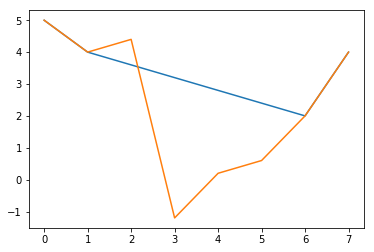

In [13]:
## 这个代码块是为了帮助你检验自己的答案是否正确的
poisson_filling = [ 5.,   4.,   3.6,  3.2,  2.8, 2.4,  2.,   4. ]
plot (poisson_filling) 
gradient_composite = [ 5.,   4.,   4.4, -1.2,  0.2,  0.6,  2.,   4. ]
plot (gradient_composite) 

## 第二部分 2D泊松重建（10分）

我们定义邻居像素集合为四联通域
则问题满足以下关系
```python
v(i,j) - v(i-1, j) = s(i,j) - s(i-1, j)
v(i,j) - v(i+1, j) = s(i,j) - s(i+1, j)
v(i,j) - v(i, j-1) = s(i,j) - s(i, j-1)
v(i,j) - v(i, j+1) = s(i,j) - s(i, j+1)
```
```python
4*v(i,j) - v(i-1, j) - v(i+1, j) - v(i, j-1) - v(i, j+1) = 4*s(i,j) - s(i-1, j) - s(i+1, j) - s(i, j-1) - s(i, j+1)
```
我们可以看到，问题转化之后，等式的左边就是拉普拉斯的离散形式表达。


**对于此任务，我们将对一个简单的图像计算laplacian，然后从该laplacian重构原始图像**
* 对于三通道图像，单独对每个通道进行处理(提示： 矩阵A不会变,不需要重复构建）



In [18]:
%matplotlib inline
from pylab import *

import imageio as imio
import numpy as np
import scipy.ndimage as nd
import scipy.sparse

im = imio.imread("data/test.png")[:,:,:3]/255.

def Laplacian(im):
    laplacian_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])    
    #{‘reflect’,’constant’,’nearest’,’mirror’, ‘wrap’}
    conv =  nd.convolve(im, laplacian_kernel,mode='constant')    
    return conv

def add_border(im):
    border_im = np.zeros((im.shape[0]+2,im.shape[1]+2,im.shape[2]))
    border_im[1:-1,1:-1] = im
    return border_im


def buildSystemNaive(im_shape):
    A = np.identity(np.prod(im_shape))
    size=im_shape[0]
    #complete the values of A
    ### YOUR CODE HERE

    ### END YOUR CODE
    return A

im = add_border(im)
A = buildSystemNaive(im[:,:,0].shape)

### YOUR CODE HERE

### END YOUR CODE

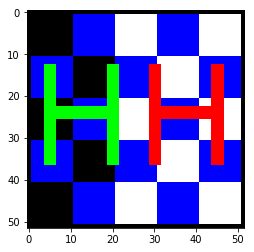

In [21]:
# The result should be the original image
imshow(im)

## 第三部分 2D泊松重建 Sparse (15分)


A需要的行和列的数量至少与被遮罩区域中的像素一样多。如果mask覆盖100,000个像素，则表示一个矩阵至少包含100,000,000,000个元素。
此时矩阵A的构建变得很费，但同时，A也非常稀疏，因为每个等式仅将一个像素与其一定数量的直接邻居相关联。

因此，对于稀疏矩阵，我们将使用稀疏矩阵和最小二乘法求解器。在这一部分,将A转换为压缩格式A = A.tocsr（）或A.tocsc（）以大大提高求解器的性能。

在这里迭代求解器可以使用库里的任何一个，http://www.scipy-lectures.org/advanced/scipy_sparse/solvers.html


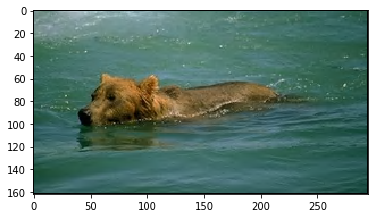

In [22]:
%matplotlib inline
from pylab import *

import numpy as np
from scipy.sparse import linalg 
import scipy.sparse as sp

im =  imio.imread("data/bear2.png")[:,:,:3]/255.

def Laplacian(im):
    laplacian_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])    
    #{‘reflect’,’constant’,’nearest’,’mirror’, ‘wrap’}
    conv =  nd.convolve(im, laplacian_kernel,mode='constant')    
    return conv

def add_border(im):
    border_im = np.zeros((im.shape[0]+2,im.shape[1]+2,im.shape[2]))
    border_im[1:-1,1:-1] = im
    return border_im

im = add_border(im)
imshow(im)



def buildSystemSparse(im_shape):
    sizey,sizex=im_shape
    ### YOUR CODE HERE

    ### END YOUR CODE
    return A

# this is done once for all three channels
A = buildSystemSparse(im[:,:,0].shape)

### YOUR CODE HERE


### END YOUR CODE

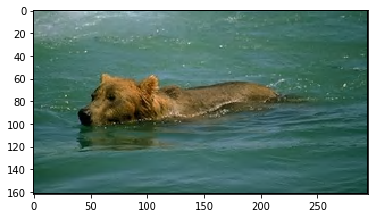

In [13]:
# The result should be the original image
result =np.dstack((red,green,blue))
imshow(result)

## 第四部分：二维泊松融合 (20分)

HINT: You can do this using the mask (and its inverse) and the laplacian operator with the fg and bg



In [15]:
%matplotlib inline
from pylab import *

import imageio as imio
import numpy as np
from IPython.display import clear_output
import scipy.ndimage as nd
import scipy.sparse

mask = imio.imread("data/bear2_mask.png")[:,:,1]/255
mask_inv = 1.-mask
fg =imio.imread("data/bear2.png")[:,:,:3]/255.
bg =imio.imread("data/waterpool.png")[:,:,:3]/255.
off = [0,0]


def buildSystemSparse(im_shape,mask):
    ### YOUR CODE HERE

    ### END YOUR CODE
    return A

A = buildSystemSparse(fg[:,:,0].shape,mask_inv)

### YOUR CODE HERE


### END YOUR CODE

100%


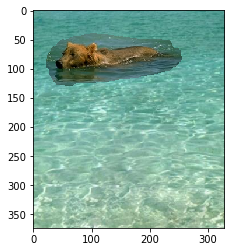

In [17]:
imshow(imio.imread('data/pasted.png')[:,:,:3]/255.)

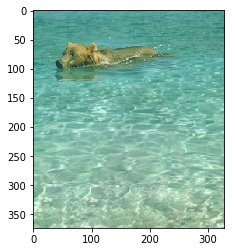

In [18]:
## 这个代码块是为了帮助你检验自己的答案是否正确的
result =np.dstack((red,green,blue))
fg=result
bg[off[0]:fg.shape[0]+off[0],off[1]:fg.shape[1]+off[1]] = bg[off[0]:fg.shape[0]+off[0],off[1]:fg.shape[1]+off[1]]*dstack((mask,mask,mask))+ fg*dstack((mask_inv,mask_inv,mask_inv))
imshow(bg)